## Layout Solution
The following cell contains the layout solution  for the two-stage amplifier.  LVS should pass when you evaluate it.

In [1]:
from bag.layout.routing import TrackID
from bag.layout.template import TemplateBase

from xbase_demo.demo_layout.core import AmpCS, AmpSFSoln


class AmpChain(TemplateBase):
    def __init__(self, temp_db, lib_name, params, used_names, **kwargs):
        TemplateBase.__init__(self, temp_db, lib_name, params, used_names, **kwargs)
        self._sch_params = None

    @property
    def sch_params(self):
        return self._sch_params

    @classmethod
    def get_params_info(cls):
        return dict(
            cs_params='common source amplifier parameters.',
            sf_params='source follower parameters.',
            show_pins='True to draw pin geometries.',
        )

    def draw_layout(self):
        """Draw the layout of a transistor for characterization.
        """

        cs_params = self.params['cs_params'].copy()
        sf_params = self.params['sf_params'].copy()
        show_pins = self.params['show_pins']

        cs_params['show_pins'] = False
        sf_params['show_pins'] = False

        # create layout masters for subcells we will add later
        cs_master = self.new_template(params=cs_params, temp_cls=AmpCS)
        sf_master = self.new_template(params=sf_params, temp_cls=AmpSFSoln)

        # add subcell instances
        cs_inst = self.add_instance(cs_master, 'XCS')
        # add source follower to the right of common source
        x0 = cs_inst.bound_box.right_unit
        sf_inst = self.add_instance(sf_master, 'XSF', loc=(x0, 0), unit_mode=True)

        # get VSS wires from AmpCS/AmpSF
        cs_vss_warr = cs_inst.get_all_port_pins('VSS')[0]
        sf_vss_warrs = sf_inst.get_all_port_pins('VSS')
        # only connect bottom VSS wire of source follower
        if len(sf_vss_warrs) < 2 or sf_vss_warrs[0].track_id.base_index < sf_vss_warrs[1].track_id.base_index:
            sf_vss_warr = sf_vss_warrs[0]
        else:
            sf_vss_warr = sf_vss_warrs[1]

        # connect VSS of the two blocks together
        vss = self.connect_wires([cs_vss_warr, sf_vss_warr])[0]

        # get layer IDs from VSS wire
        hm_layer = vss.layer_id
        vm_layer = hm_layer + 1
        top_layer = vm_layer + 1

        # calculate template size
        tot_box = cs_inst.bound_box.merge(sf_inst.bound_box)
        self.set_size_from_bound_box(top_layer, tot_box, round_up=True)

        # get subcell ports as WireArrays so we can connect them
        vmid0 = cs_inst.get_all_port_pins('vout')[0]
        vmid1 = sf_inst.get_all_port_pins('vin')[0]
        vdd0 = cs_inst.get_all_port_pins('VDD')[0]
        vdd1 = sf_inst.get_all_port_pins('VDD')[0]

        # get vertical VDD TrackIDs
        vdd0_tid = TrackID(vm_layer, self.grid.coord_to_nearest_track(vm_layer, vdd0.middle))
        vdd1_tid = TrackID(vm_layer, self.grid.coord_to_nearest_track(vm_layer, vdd1.middle))

        # connect VDD of each block to vertical M5
        vdd0 = self.connect_to_tracks(vdd0, vdd0_tid)
        vdd1 = self.connect_to_tracks(vdd1, vdd1_tid)
        # connect M5 VDD to top M6 horizontal track
        vdd_tidx = self.grid.get_num_tracks(self.size, top_layer) - 1
        vdd_tid = TrackID(top_layer, vdd_tidx)
        vdd = self.connect_to_tracks([vdd0, vdd1], vdd_tid)

        # connect vmid using vertical track in the middle of the two templates
        mid_tid = TrackID(vm_layer, self.grid.coord_to_nearest_track(vm_layer, x0, unit_mode=True))
        vmid = self.connect_to_tracks([vmid0, vmid1], mid_tid)

        # add pins on wires
        self.add_pin('vmid', vmid, show=show_pins)
        self.add_pin('VDD', vdd, show=show_pins)
        self.add_pin('VSS', vss, show=show_pins)
        # re-export pins on subcells.
        self.reexport(cs_inst.get_port('vin'), show=show_pins)
        self.reexport(cs_inst.get_port('vbias'), net_name='vb1', show=show_pins)
        self.reexport(sf_inst.get_port('vout'), show=show_pins)
        self.reexport(sf_inst.get_port('vbias'), net_name='vb2', show=show_pins)

        # compute schematic parameters.
        self._sch_params = dict(
            cs_params=cs_master.sch_params,
            sf_params=sf_master.sch_params,
        )


import os

# import bag package
import bag
from bag.io import read_yaml

# import BAG demo Python modules
import xbase_demo.core as demo_core

# load circuit specifications from file
spec_fname = os.path.join(os.environ['BAG_WORK_DIR'], 'specs_demo/demo.yaml')
top_specs = read_yaml(spec_fname)

# obtain BagProject instance
local_dict = locals()
if 'bprj' in local_dict:
    print('using existing BagProject')
    bprj = local_dict['bprj']
else:
    print('creating BagProject')
    bprj = bag.BagProject()

demo_core.run_flow(bprj, top_specs, 'amp_chain_soln', AmpChain, run_lvs=True, lvs_only=True)

creating BagProject
computing layout
ext_w0 = 1, ext_wend=1, ytop=2592
final: ext_w0 = 1, ext_wend=1, ytop=2592
{'s': WireArray(TrackID(layer=3, track=7, num=9, pitch=2), 1109, 1265, 0.001), 'd': WireArray(TrackID(layer=3, track=8, num=8, pitch=2), 1231, 1387, 0.001), 'g': WireArray(TrackID(layer=3, track=8, num=8, pitch=2), 915, 1071, 0.001)}
WireArray(TrackID(layer=3, track=8, num=8, pitch=2), 915, 1071, 0.001)
6.5
ext_w0 = 1, ext_wend=7, ytop=2880
ext_w0 = 2, ext_wend=9, ytop=3024
final: ext_w0 = 1, ext_wend=7, ytop=2880
creating layout
layout done
computing AMP_CHAIN schematics
creating AMP_CHAIN schematics
running lvs
Running tasks, Press Ctrl-C to cancel.
lvs passed
lvs log is /users/erichang/projects/bag_gen/BAG2_cds_ff_mpt/pvs_run/lvs_run_dir/DEMO_AMP_CHAIN/AMP_CHAIN/lvsLog_20180906_112850xbhqztn3
LVS flow done


## AmpChain Schematic Generator Solution
The AmpChain schematic generation solution is shown below, evaluate it to run through the flow.  Note that it uses the `amp_chain_soln` schematic template instead of the `amp_chain` schematic template you are supposed to fill out.  Change `amp_chain_soln` to `amp_chain` in the `yaml_file` class variable if you wish to debug your schematic template.

using existing BagProject
computing layout
ext_w0 = 1, ext_wend=1, ytop=2592
final: ext_w0 = 1, ext_wend=1, ytop=2592
{'s': WireArray(TrackID(layer=3, track=7, num=9, pitch=2), 1109, 1265, 0.001), 'd': WireArray(TrackID(layer=3, track=8, num=8, pitch=2), 1231, 1387, 0.001), 'g': WireArray(TrackID(layer=3, track=8, num=8, pitch=2), 915, 1071, 0.001)}
WireArray(TrackID(layer=3, track=8, num=8, pitch=2), 915, 1071, 0.001)
6.5
ext_w0 = 1, ext_wend=7, ytop=2880
ext_w0 = 2, ext_wend=9, ytop=3024
final: ext_w0 = 1, ext_wend=7, ytop=2880
creating layout
layout done
creating AMP_CHAIN schematics
running lvs
Running tasks, Press Ctrl-C to cancel.
lvs passed
lvs log is /users/erichang/projects/bag_gen/BAG2_cds_ff_mpt/pvs_run/lvs_run_dir/DEMO_AMP_CHAIN/AMP_CHAIN/lvsLog_20180906_112931rlh5cdgf
computing AMP_CHAIN_tb_dc schematics
creating AMP_CHAIN_tb_dc schematics
computing AMP_CHAIN_tb_ac_tran schematics
creating AMP_CHAIN_tb_ac_tran schematics
schematic done
setting up AMP_CHAIN_tb_dc
running si

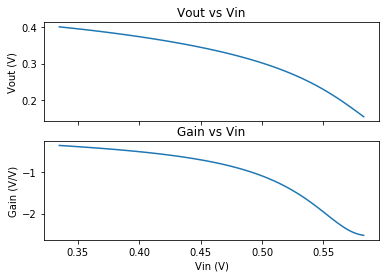

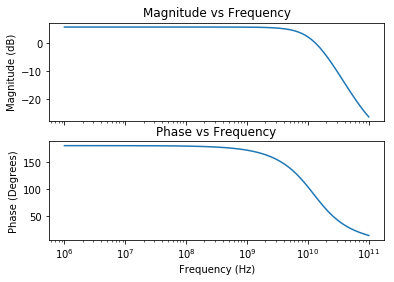

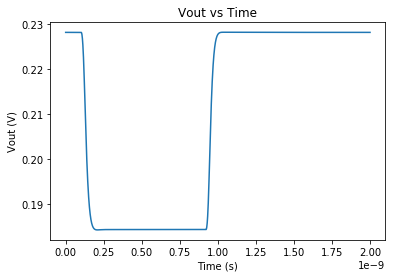

In [2]:
%matplotlib inline

import os

from bag.design import Module


# noinspection PyPep8Naming
class demo_templates__amp_chain(Module):
    """Module for library demo_templates cell amp_chain.

    Fill in high level description here.
    """

    # hard coded netlist flie path to get jupyter notebook working.
    yaml_file = os.path.join(os.environ['BAG_WORK_DIR'], 'BAG_XBase_demo', 
                             'BagModules', 'demo_templates', 'netlist_info', 'amp_chain_soln.yaml') 

    def __init__(self, bag_config, parent=None, prj=None, **kwargs):
        Module.__init__(self, bag_config, self.yaml_file, parent=parent, prj=prj, **kwargs)

    @classmethod
    def get_params_info(cls):
        # type: () -> Dict[str, str]
        """Returns a dictionary from parameter names to descriptions.

        Returns
        -------
        param_info : Optional[Dict[str, str]]
            dictionary from parameter names to descriptions.
        """
        return dict(
            cs_params='common-source amplifier parameters dictionary.',
            sf_params='source-follwer amplifier parameters dictionary.',
        )

    def design(self, cs_params=None, sf_params=None):
        self.instances['XCS'].design(**cs_params)
        self.instances['XSF'].design(**sf_params)


import os

# import bag package
import bag
from bag.io import read_yaml

# import BAG demo Python modules
import xbase_demo.core as demo_core
from xbase_demo.demo_layout.core import AmpChainSoln

# load circuit specifications from file
spec_fname = os.path.join(os.environ['BAG_WORK_DIR'], 'specs_demo/demo.yaml')
top_specs = read_yaml(spec_fname)

# obtain BagProject instance
local_dict = locals()
if 'bprj' in local_dict:
    print('using existing BagProject')
    bprj = local_dict['bprj']
else:
    print('creating BagProject')
    bprj = bag.BagProject()

demo_core.run_flow(bprj, top_specs, 'amp_chain', AmpChainSoln, sch_cls=demo_templates__amp_chain, run_lvs=True)